# Load Packages

In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns

import gymnasium as gym
from typing import NamedTuple
from pathlib import Path
from tqdm import tqdm
import matplotlib.pyplot as plt
from gymnasium.envs.toy_text.frozen_lake import generate_random_map

# Utilis

In [ ]:
class Params(NamedTuple):
    total_episodes: int
    learning_rate: float
    gamma: float  # Discounting rate
    epsilon: float  # Exploration probability
    map_size: int  # Number of tiles of one side of the squared environment
    seed: int
    is_slippery: bool  # If true the player will move in intended direction with probability of 1/3 else will move in either perpendicular direction with equal probability of 1/3 in both directions
    n_runs: int  # Number of runs
    action_size: int
    state_size: int
    proba_frozen: float  # Probability that a tile is frozen
    savefig_folder: Path  # Root folder where plots are saved


def qtable_directions_map(qtable, map_size):
    qtable_val_max = qtable.max(-1).reshape(map_size, map_size)
    qtable_best_action = qtable.argmax(-1).reshape(map_size, map_size)

    directions = {0: "←", 1: "↓", 2: "→", 3: "↑"}
    qtable_directions = np.empty(qtable_best_action.flatten().shape, dtype=str)

    eps = np.finfo(float).eps
    for idx, val in enumerate(qtable_best_action.flatten()):
        if qtable_val_max.flatten()[idx] > eps:
            qtable_directions[idx] = directions[val]
    qtable_directions = qtable_directions.reshape(map_size, map_size)
    return qtable_val_max, qtable_directions


def plot_states_actions_distribution(states, actions, map_size, params):
    labels = {"LEFT": 0, "DOWN": 1, "RIGHT": 2, "UP": 3}

    fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(15, 5))
    sns.histplot(data=states, ax=ax[0], kde=True)
    ax[0].set_title("States")
    sns.histplot(data=actions, ax=ax[1])
    ax[1].set_xticks(list(labels.values()), labels=labels.keys())
    ax[1].set_title("Actions")
    fig.tight_layout()
    img_title = f"frozenlake_states_actions_distrib_{map_size}x{map_size}.png"
    fig.savefig(params.savefig_folder / img_title, bbox_inches="tight")
    plt.show()


def plot_q_values_map(qtable, env, map_size, params):
    qtable_val_max, qtable_directions = qtable_directions_map(qtable, map_size)

    fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(15, 5))
    ax[0].imshow(env.render())
    ax[0].axis("off")
    ax[0].set_title("Last frame")

    # Plot the policy
    sns.heatmap(
        qtable_val_max,
        annot=qtable_directions,
        fmt="",
        ax=ax[1],
        cmap=sns.color_palette("Blues", as_cmap=True),
        linewidths=0.7,
        linecolor="black",
        xticklabels=[],
        yticklabels=[],
        annot_kws={"fontsize": "xx-large"},
    ).set(title="Learned Q-values\nArrows represent best action")
    for _, spine in ax[1].spines.items():
        spine.set_visible(True)
        spine.set_linewidth(0.7)
        spine.set_color("black")
    img_title = f"frozenlake_q_values_{map_size}x{map_size}.png"
    fig.savefig(params.savefig_folder / img_title, bbox_inches="tight")
    plt.show()


def postprocess(episodes, params, rewards, steps, hue, hue_val):
    df = pd.DataFrame(
        data={
            "episodes": np.tile(episodes, params.n_runs),
            "rewards": rewards.flatten("F"),
            "steps": steps.flatten("F")
        }
    )

    df["cum_rewards"] = rewards.cumsum(-1).flatten()
    df[hue] = np.repeat(hue_val, df.shape[0])

    st = pd.DataFrame({"episodes": episodes, "steps": steps.mean(0)})
    st[hue] = np.repeat(hue_val, st.shape[0])

    return df, st


def plot_steps_and_rewards(rewards_df, steps_df, params, hue="map_size"):
    fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(15, 5))
    sns.lineplot(
        data=rewards_df, x="episodes", y="cum_rewards", hue=hue, ax=ax[0]
    )
    ax[0].set(ylabel="Cumulated rewards")

    sns.lineplot(data=steps_df, x="episodes", y="steps", hue=hue, ax=ax[1])
    ax[1].set(ylabel="Averaged steps number")

    for axi in ax:
        axi.legend(title="map size")
    fig.tight_layout()
    img_title = f"frozenlake_steps_and_rewards_{hue}.png"
    fig.savefig(params.savefig_folder / img_title, bbox_inches="tight")
    plt.show()

# Q-Learning

In [ ]:
class Qlearning:
    def __init__(self, learning_rate, gamma, state_size, action_size):
        self.learning_rate = learning_rate
        self.gamma = gamma
        self.state_size = state_size
        self.action_size = action_size
        self.reset_qtable()

    def update(self, state, action, reward, next_state):
        delta = self.learning_rate * (reward + self.gamma * max(self.qtable[next_state]) - self.qtable[state, action])
        self.qtable[state, action] += delta

    def reset_qtable(self):
        self.qtable = np.zeros([self.state_size, self.action_size])

# $\varepsilon$-greedy policy

In [ ]:
class EpsilonGreedy:
    def __init__(self, epsilon):
        self.epsilon = epsilon

    def take_action(self, action_space, state, qtable):
        val = np.random.uniform(size=1)

        if val < self.epsilon or np.all(qtable[state] == qtable[state, 0]):
            return np.random.choice(action_space)

        return qtable[state].argmax()

# Trainer

In [ ]:
class FrozenLake:
    def __init__(self, params):
        self.params = params
        self.params.savefig_folder.mkdir(parents=True, exist_ok=True)
        self.env = gym.make(
            "FrozenLake-v1",
            is_slippery=params.is_slippery,
            render_mode="rgb_array",
            desc=generate_random_map(size=params.map_size, p=params.proba_frozen, seed=params.seed)
        )
        self.env.action_space.seed(params.seed)

        self.params = self.params._replace(action_size=self.env.action_space.n)
        self.params = self.params._replace(state_size=self.env.observation_space.n)

        self.learner = Qlearning(self.params.learning_rate, self.params.gamma, self.params.state_size, self.params.action_size)
        self.policy = EpsilonGreedy(self.params.epsilon)

    def train(self):
        self.episodes = np.arange(self.params.total_episodes)
        self.rewards = np.zeros([self.params.n_runs, self.params.total_episodes])
        self.steps = np.zeros_like(self.rewards)

        self.qtables = np.zeros([self.params.n_runs, self.params.state_size, self.params.action_size])
        self.all_states, self.all_actions = [], []

        for run in range(self.params.n_runs):
            self.learner.reset_qtable()

            for episode in tqdm(self.episodes, desc=f"Run {run}/{self.params.n_runs} - Episodes", leave=False):
                state = self.env.reset(seed=self.params.seed)[0]

                while True:
                    action = self.policy.take_action(self.params.action_size, state, self.learner.qtable)
                    self.all_states.append(state)
                    self.all_actions.append(action)

                    next_state, reward, terminated, truncated, info = self.env.step(action)
                    self.learner.update(state, action, reward, next_state)

                    self.rewards[run, episode] += reward
                    self.steps[run, episode] += 1

                    state = next_state
                    if terminated or truncated:
                        break

            self.qtables[run] = self.learner.qtable

    def hist_state_action(self):
        plot_states_actions_distribution(
            states=self.all_states, actions=self.all_actions, map_size=self.params.map_size, params=self.params
        )

    def avg_qval_map(self):
        plot_q_values_map(self.qtables.mean(0), self.env, self.params.map_size, self.params)

    def data_process(self, hue, hue_val):
        return postprocess(self.episodes, self.params, self.rewards, self.steps, hue, hue_val)

# Experiments

## Sensitivity study for the number of states

Visualization for map_size = 4


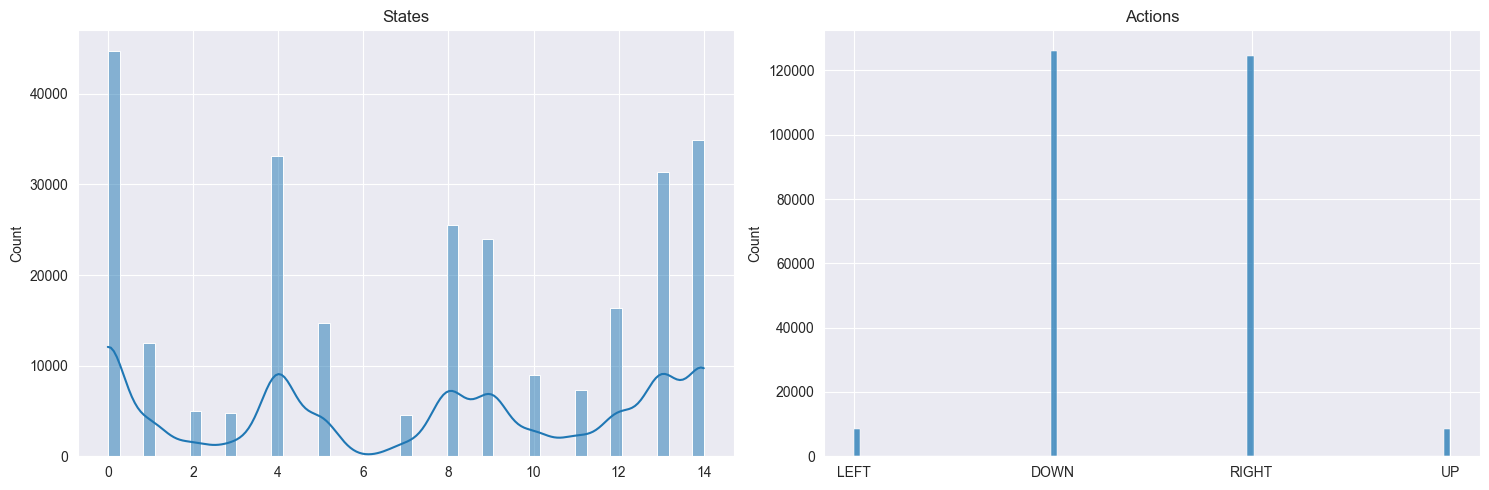

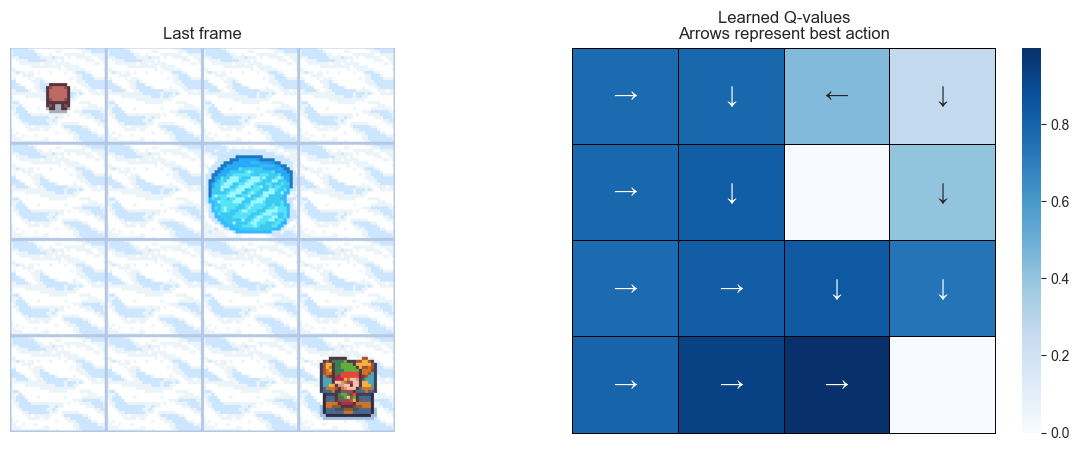

Visualization for map_size = 7


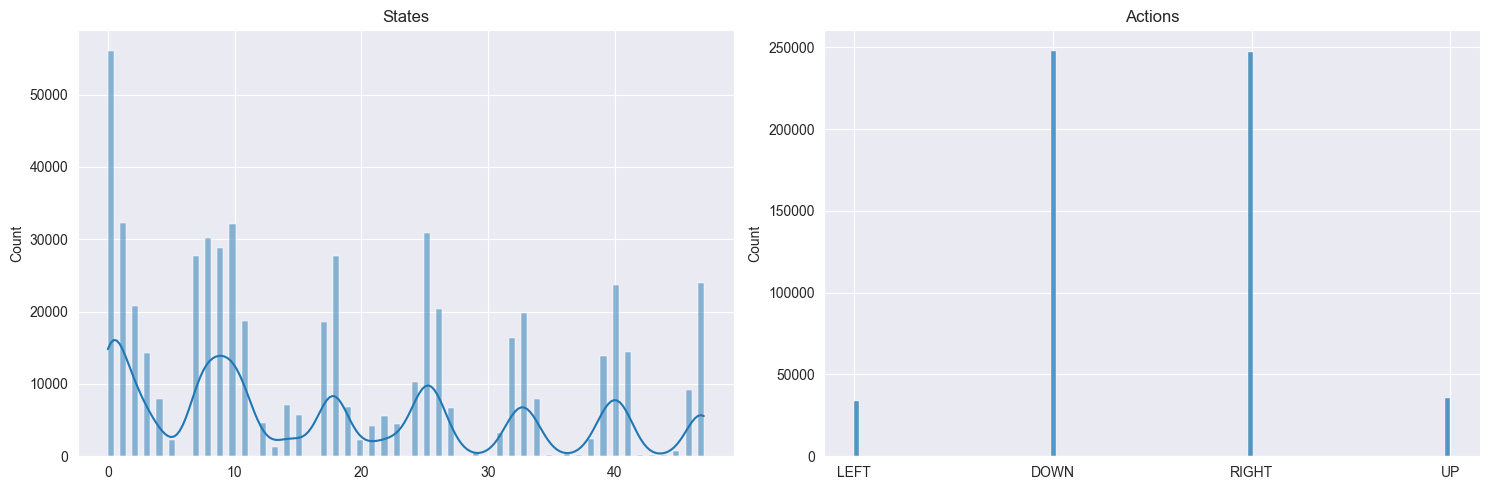

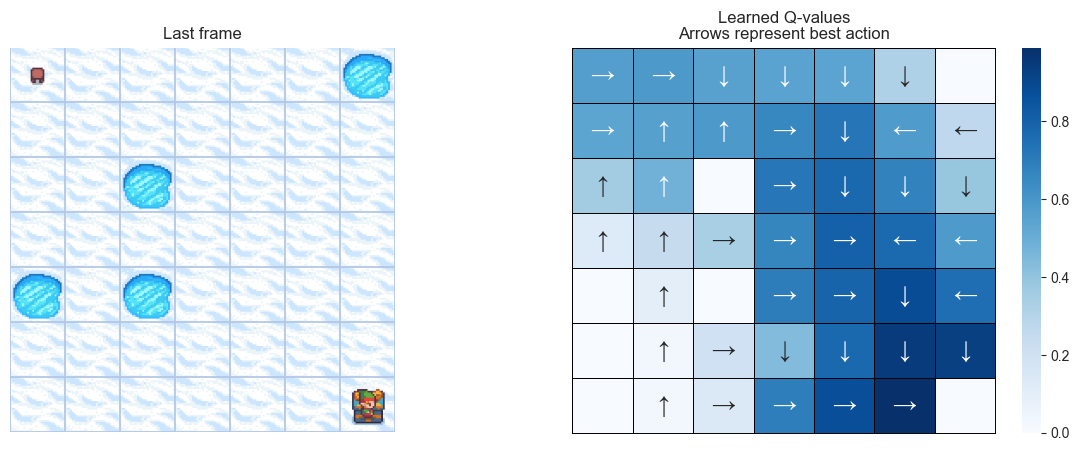

Visualization for map_size = 9


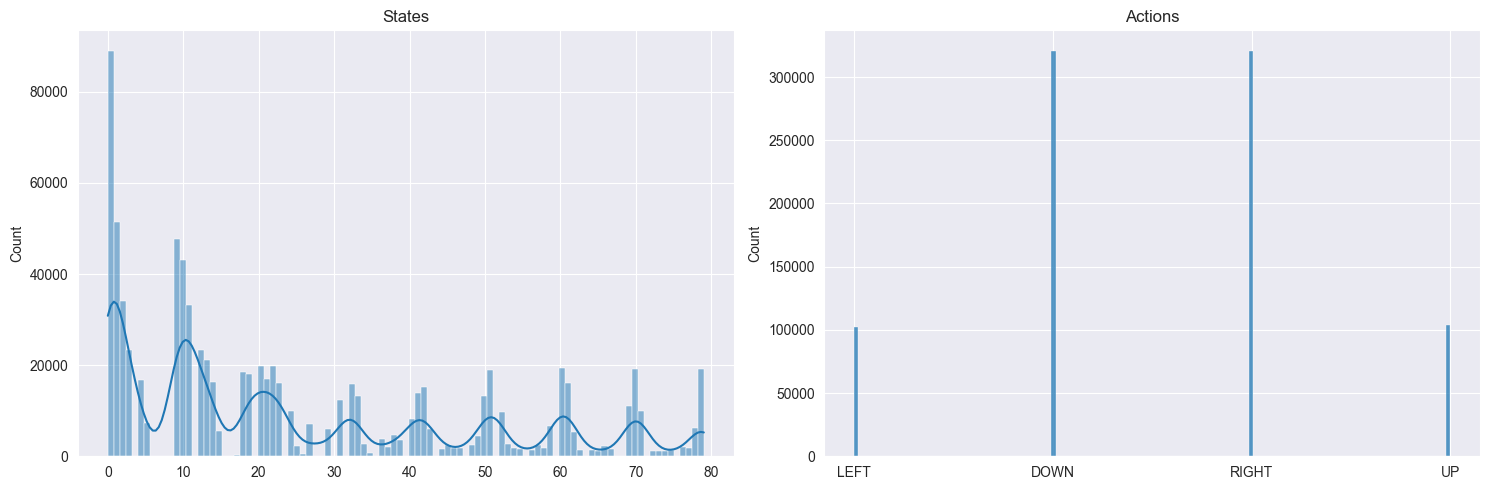

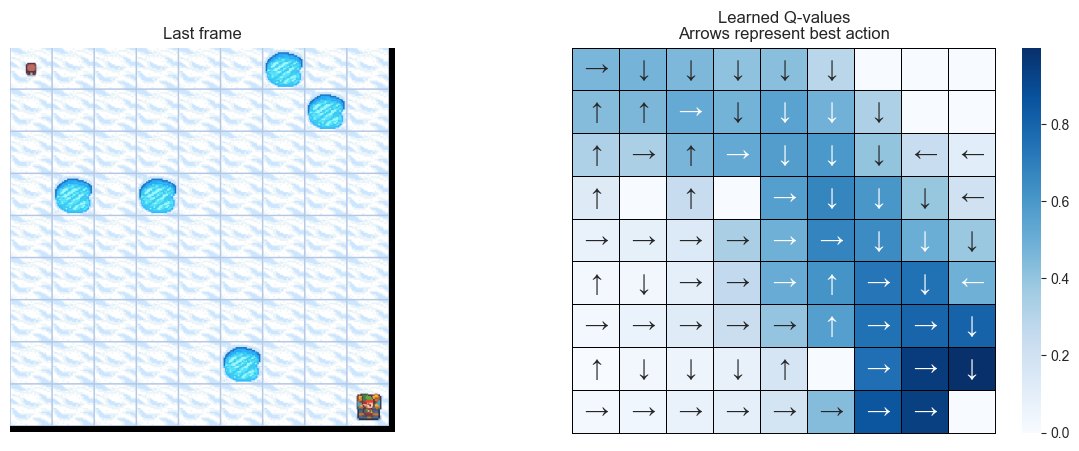

In [9]:
rewards_df = pd.DataFrame()
steps_df = pd.DataFrame()

map_sizes = [4, 7, 9]
for map_size in map_sizes:
    params = Params(
        total_episodes=2000, learning_rate=0.8, gamma=0.95,
        epsilon=0.1, map_size=map_size, seed=123,
        is_slippery=False, n_runs=20, action_size=None,
        state_size=None, proba_frozen=0.9, savefig_folder=Path("./")
    )

    myFL = FrozenLake(params)
    myFL.train()

    print(f"Visualization for map_size = {map_size}")
    myFL.hist_state_action()
    myFL.avg_qval_map()

    res, st = myFL.data_process(hue="map_size", hue_val=f"{map_size}x{map_size}")
    rewards_df = pd.concat([rewards_df, res])
    steps_df = pd.concat([steps_df, st])

    myFL.env.close()

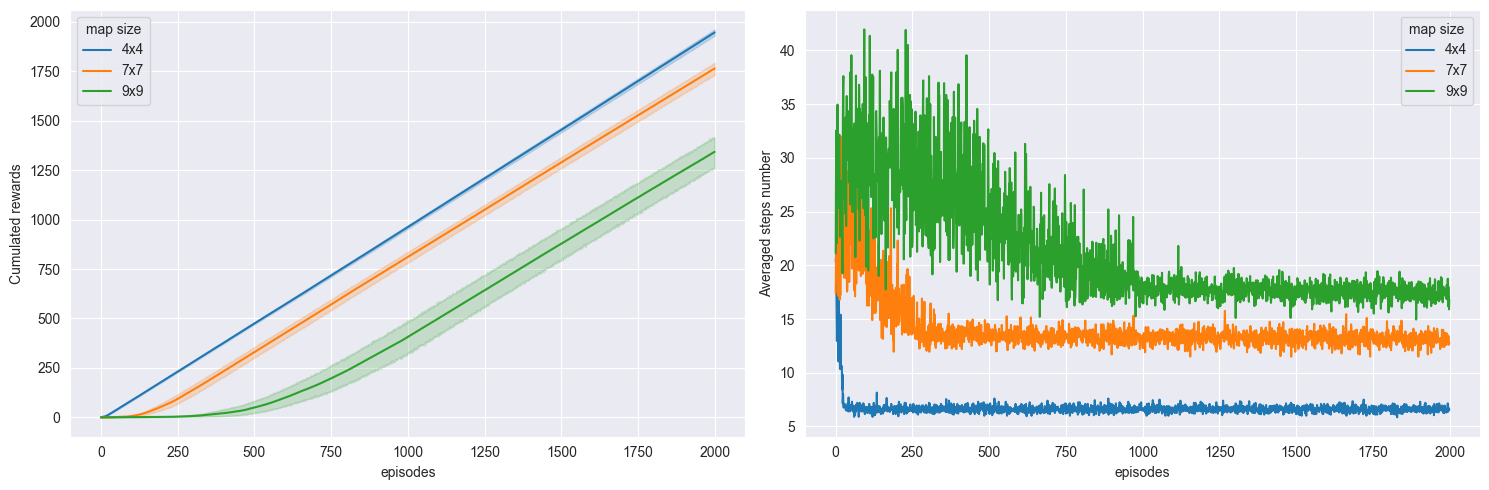

In [10]:
plot_steps_and_rewards(rewards_df, steps_df, myFL.params)

## Sensitivity study for $\varepsilon$

Visualization for epsilon = 0.1


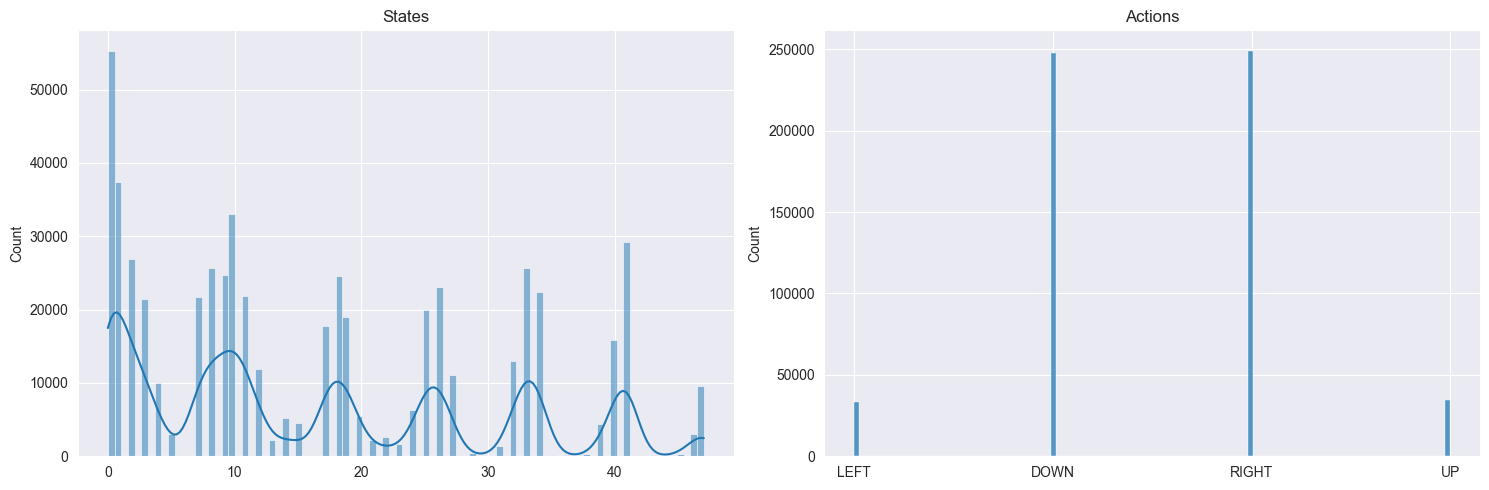

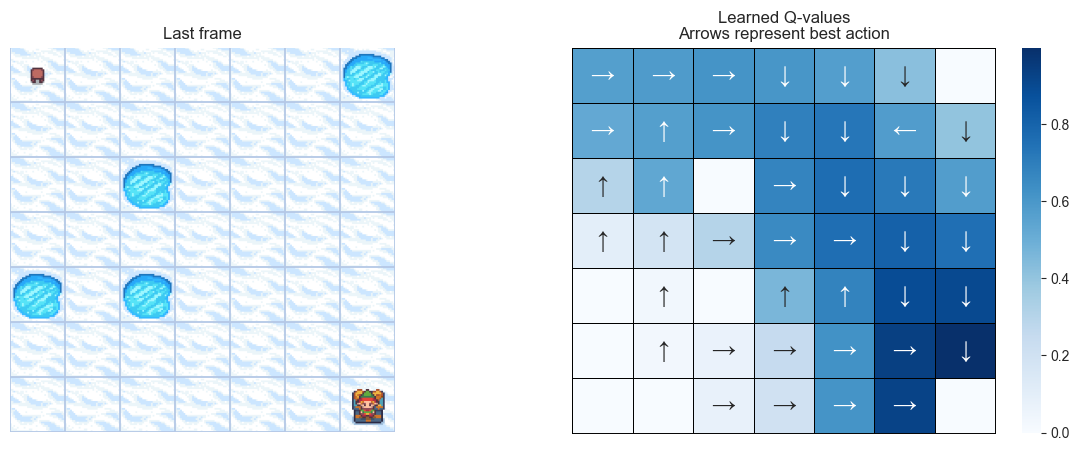

Visualization for epsilon = 0.3


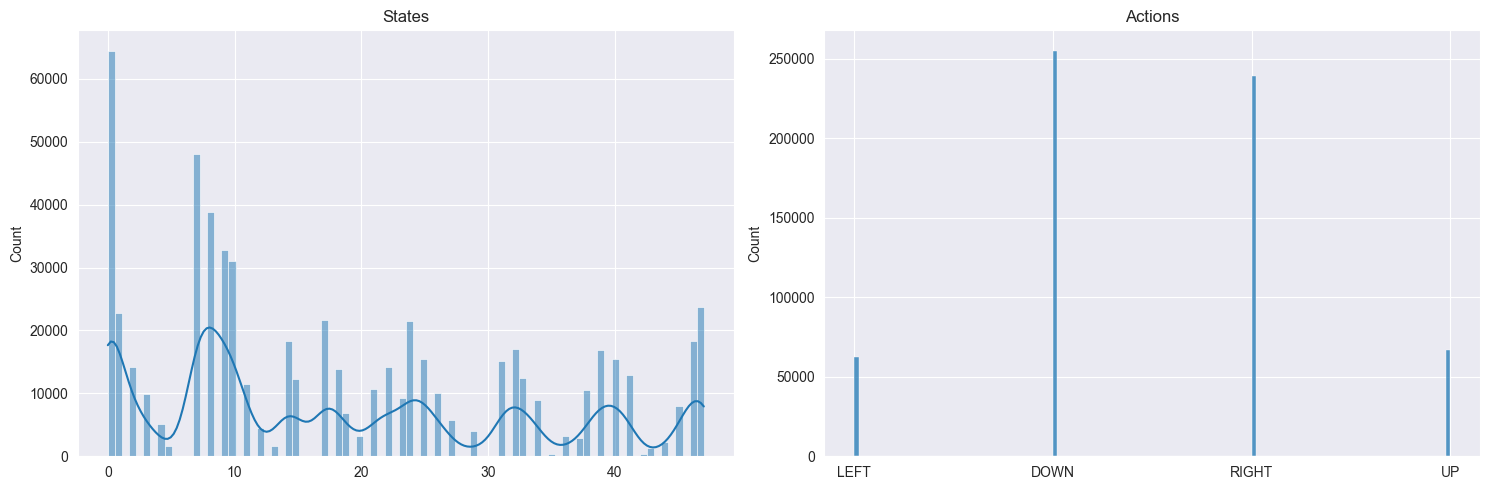

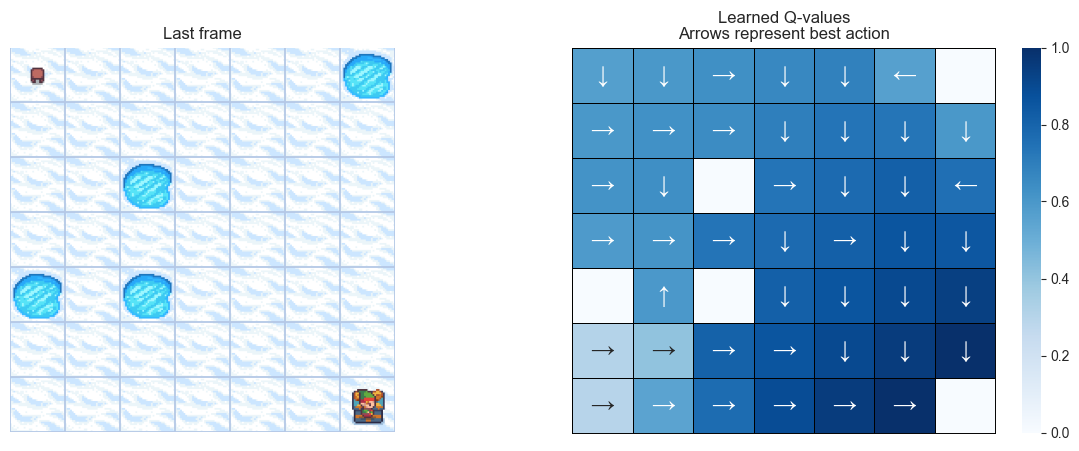

Visualization for epsilon = 0.5


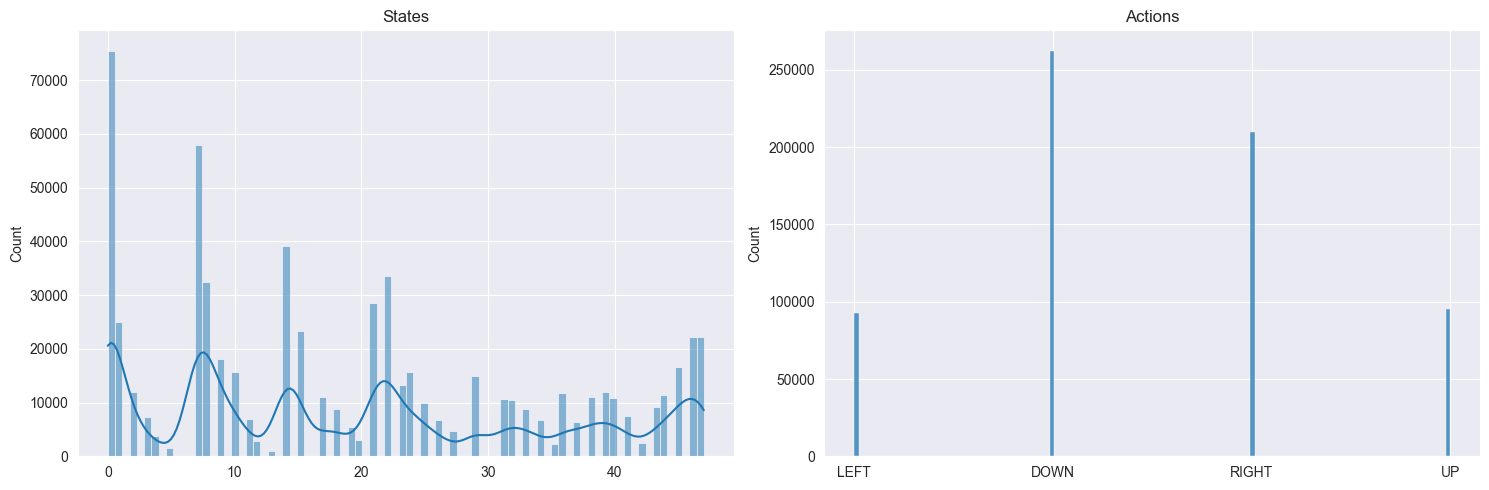

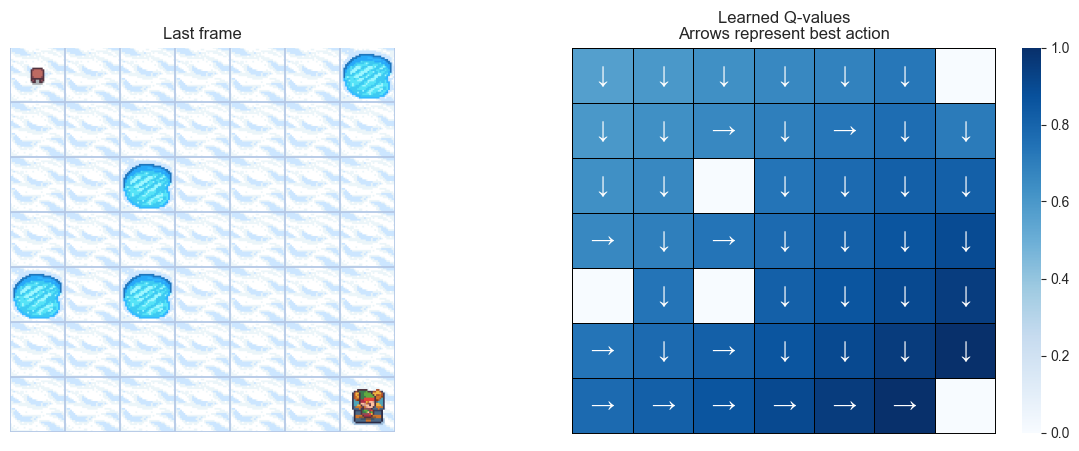

In [11]:
rewards_df = pd.DataFrame()
steps_df = pd.DataFrame()
epsilons = [0.1, 0.3, 0.5]


for epsilon in epsilons:
    params = Params(
        total_episodes=2000, learning_rate=0.8, gamma=0.95,
        epsilon=epsilon, map_size=7, seed=123,
        is_slippery=False, n_runs=20, action_size=None,
        state_size=None, proba_frozen=0.9, savefig_folder=Path("./")
    )

    myFL = FrozenLake(params)
    myFL.train()

    print(f"Visualization for epsilon = {epsilon}")
    myFL.hist_state_action()
    myFL.avg_qval_map()

    res, st = myFL.data_process(hue="epsilon", hue_val=str(epsilon))
    rewards_df = pd.concat([rewards_df, res])
    steps_df = pd.concat([steps_df, st])

    myFL.env.close()

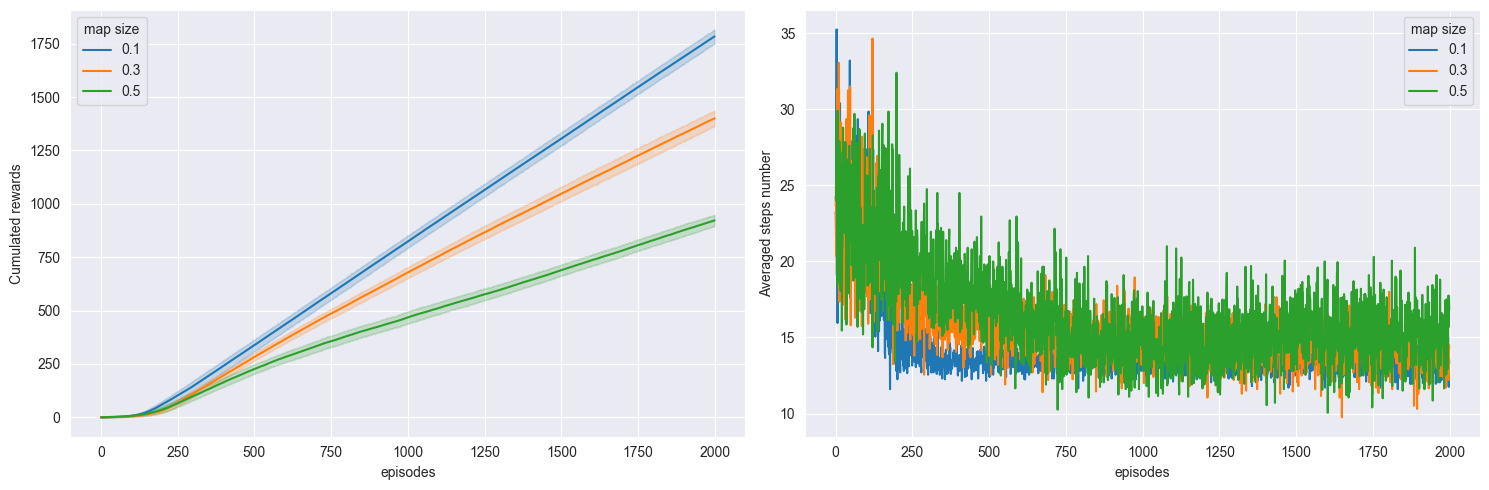

In [12]:
plot_steps_and_rewards(rewards_df, steps_df, myFL.params, hue="epsilon")
